In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from rl_analysis.io.df import dlight_exclude_toml
from rl_analysis.plotting import setup_plotting_env, clean_ticks, savefig
from rl_analysis.util import pd_zscore
from tqdm.auto import tqdm
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

# Helper functions

## load in new dlight data and preprocess

In [3]:
import toml

with open("../analysis_configuration.toml", "r") as f:
    analysis_config = toml.load(f)

In [4]:
raw_dirs = analysis_config["raw_data"]
proc_dirs = analysis_config["intermediate_results"]
dlight_cfg = analysis_config["dlight_basic_analysis"]
dlight_common_cfg = analysis_config["dlight_common"]
figure_cfg = analysis_config["figures"]

In [5]:
use_dct = dlight_exclude_toml(
    os.path.join(raw_dirs["dlight"], "dlight_photometry_processed_full.toml"),
    **analysis_config["dlight_common"]
)

In [6]:
dlight_df = pd.read_parquet(
    os.path.join(raw_dirs["dlight"], "dlight_photometry_processed_full.parquet"),
    filters=[("uuid", "in", list(use_dct.keys())), ("area", "=", "dls")],
).sort_index()

In [7]:
dlight_df["uuid"] = dlight_df["uuid"].astype("str")
dlight_df["mouse_id"] = dlight_df["mouse_id"].astype("str")

In [8]:
dlight_df = dlight_df.loc[~dlight_df["session_number"].isin([1, 2, 3, 4])].copy()

In [9]:
signal_keys = dlight_df.filter(regex="(signal|reference|reref)_dff$").columns.tolist()

In [10]:
dlight_df["labels"] = (
    dlight_df["predicted_syllable (offline)"].replace(-5, np.nan).astype("UInt8")
)
dlight_df = dlight_df.dropna(subset=["labels"])

In [11]:
def mark_threshold_crossing(values, threshold=1.96):
    locs = np.zeros((len(values),), dtype="bool")
    locs[1:] = (values.to_numpy()[:-1] <= threshold) & (
        values.to_numpy()[1:] > threshold
    )
    return pd.Series(data=locs, index=values.index)

In [12]:
dlight_df = dlight_df.dropna(subset=["signal_reref_dff_z"])

In [13]:
_tmp_pos = dlight_df.groupby("uuid", group_keys=False)["signal_reref_dff_z"].apply(
    lambda x: mark_threshold_crossing(+x, threshold=1.96)
)
_tmp_neg = dlight_df.groupby("uuid", group_keys=False)["signal_reref_dff_z"].apply(
    lambda x: mark_threshold_crossing(-x, threshold=1.96)
)

In [14]:
_tmp = _tmp_pos | _tmp_neg

In [15]:
_tmp.groupby(dlight_df["uuid"]).apply(
    lambda x: np.median(np.diff(x.loc[x == 1].index)) / 30.0
).median()

1.1166666666666667

## Likelihood of syllable transition near DA peak

In [16]:
dlight_df["transition"] = dlight_df.groupby("uuid", group_keys=False)["labels"].transform(
    lambda x: (x.diff() != 0).astype("float")
)
transition_tstamps = dlight_df.loc[dlight_df["transition"] == 1, "timestamp"]
dlight_df["transition_time"] = np.nan
dlight_df.loc[dlight_df["transition"] == 1, "transition_time"] = transition_tstamps

In [17]:
dlight_df["transition"] = dlight_df["transition"].fillna(0).astype("bool")

In [18]:
from numba import jit

In [19]:
@jit
def fast_prune_list(x, min_dist=10):
    cur_val = x[0]
    val_list = [cur_val]
    for _x in x[1:]:
        if (_x - cur_val) > min_dist:
            val_list.append(_x)
            cur_val = _x
    return np.array(val_list)

In [20]:
def extract_windows(x, peaks={}, win_border=30, remove_overlap=True):
    try:
        use_peaks = peaks[x.name]
    except KeyError:
        return None
    use_peaks = use_peaks[
        (use_peaks > win_border) & (use_peaks < (len(x) - win_border))
    ]
    if remove_overlap:
        use_peaks = fast_prune_list(use_peaks, min_dist=win_border)
    use_windows = use_peaks[:, None] + np.arange(-win_border, +win_border)
    return x.values.ravel()[use_windows]

In [21]:
from scipy.stats import norm

In [57]:
q_threshold = 0.99
z_threshold = norm.ppf(q_threshold)

In [58]:
_tmp_pos = dlight_df.groupby("uuid", group_keys=False)["signal_reref_dff_z"].apply(
    lambda x: mark_threshold_crossing(
        +pd_zscore(x.rolling(3, 1, True).mean().diff()), threshold=z_threshold
    )
)
pos_peaks = (
    _tmp_pos.groupby(dlight_df["uuid"], group_keys=False)
    .apply(lambda x: np.flatnonzero(x.values))
    .to_dict()
)

In [59]:
trans_wins = dlight_df.groupby("uuid")["transition"].apply(
    lambda x: extract_windows(x, peaks=deepcopy(pos_peaks), win_border=90)
)

In [60]:
all_wins = np.concatenate(trans_wins.values, axis=0)

In [61]:
# fast permute?

In [62]:
from numba import jit, prange

In [63]:
@jit(nopython=True, parallel=True)
def fast_circshift(x):
    new_x = np.zeros_like(x)
    for i in prange(x.shape[0]):
        new_x[i] = np.roll(x[i], np.random.randint(-100, 100))
    return new_x

In [64]:
nshuffles = 1000
shuffle_means = []
for i in tqdm(range(nshuffles)):
    shuffle_means.append(fast_circshift(all_wins).mean(axis=0))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [65]:
shuffle_means = np.array(shuffle_means)

In [66]:
xlen = all_wins.shape[1]

In [67]:
xvec = np.arange(-xlen // 2, +xlen // 2) / 30.0

In [68]:
pd.Series([1, 2, 3]).diff()

0    NaN
1    1.0
2    1.0
dtype: float64

In [69]:
setup_plotting_env()

In [70]:
peak_loc = xvec[np.concatenate(trans_wins, axis=0).mean(axis=0).argmax()]

In [71]:
peak_loc

-0.2

In [72]:
np.mean(np.concatenate(trans_wins, axis=0).astype("float"),axis=0).argmax()

84

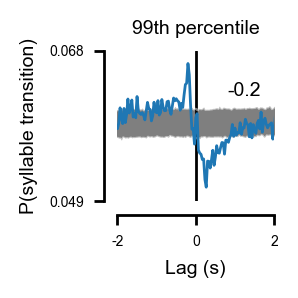

In [73]:
fig, ax = plt.subplots(1, figsize=(1.5, 1.5))
ax.plot(xvec, np.concatenate(trans_wins.values, axis=0).mean(axis=0))
ax.fill_between(
    xvec,
    np.quantile(shuffle_means, 0.025, axis=0),
    np.quantile(shuffle_means, 0.975, axis=0),
    facecolor=[0] * 3,
    alpha=0.5,
    zorder=-200,
)
ax.set_title(f"{int(1e2 * q_threshold):d}th percentile")
ax.axvline(x=0, color=plt.rcParams["axes.edgecolor"], zorder=-300)
ax.text(0.7, 0.7, f"{peak_loc:0.2g}", transform=ax.transAxes)

# ax.axhline(y=0, color=plt.rcParams["axes.edgecolor"], zorder=-300)
plt.ylabel("P(syllable transition)")
plt.xlabel("Lag (s)")
plt.xlim(-2, +2)
clean_ticks(ax, "y", precision=3)
clean_ticks(ax, "x", precision=2, dtype=int)
sns.despine(offset=5)
fig.tight_layout()
savefig(
    fig,
    os.path.join(
        figure_cfg["store_dir"],
        f"dlight_transient_syllable_transition_probability_q{q_threshold}",
    ),
)